#### LightFM

Quickstart Example:

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

data = fetch_movielens(min_rating=5.0)
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

precision_at_k(model, data['test'], k=5).mean()

0.050462347

In [7]:
data

{'train': <943x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 19048 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 2153 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [4]:
data['train']

<943x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 19048 stored elements in COOrdinate format>

Not helpful...

### Data

![](images/candy.jpg)

![](images/influenster.png)

### Structure

In [8]:
import pandas as pd

df = pd.read_csv('data/candy.csv')

df.sample(5)

,item,user,review
1600,Ferrero Collection Fine Assorted Confections,ivanwood,5
14727,Werther's Original Caramel Hard Candies,christopherlove,3
13457,Reese's Peanut Butter Egg,jenkinsdonna,5
6302,Jolly Rancher Hard Candy Original Flavors Asso...,randywright,5
9633,Twizzlers Pull-N-Peel Candy Cherry,jamescarson,5


In [9]:
df[df['user'] == 'zjohnson']

,item,user,review
2186,Skittles Sour Candy,zjohnson,5
6022,Haribo Sour Gold Bears Gummi Candy,zjohnson,5
7919,Starburst Original Fruit Chews,zjohnson,5
8382,Sour Patch Watermelon,zjohnson,5
12304,Sour Patch Kids Candy,zjohnson,4


In [10]:
df['item'].value_counts()[:5]

Twix                                       340
Snickers Chocolate Bar                     330
Werther's Original Caramel Hard Candies    322
M&Ms Peanut Chocolate Candy                310
M&Ms Milk Chocolate Candy                  273
Name: item, dtype: int64

In [11]:
df['item'].unique().shape

(142,)

In [12]:
df['user'].unique().shape

(2531,)

In [13]:
df['review'].value_counts()

5    12977
4     2554
3      967
2      372
1      364
Name: review, dtype: int64

In [14]:
df.groupby('user')['item'].count().mean()

6.809166337416041

Back to `data['train']`...

In [15]:
data['train']

<943x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 19048 stored elements in COOrdinate format>

In [16]:
data['train'].todense()

matrix([[5., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [5., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 5., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
data['item_labels']

array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)

### Sparsity

Data needs to look like this:

In [18]:
ex = pd.DataFrame([
    [0, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1],
    [0, 0, 0, 1, 1, 1]], 
    columns=['twix', 'mars', 'reeses', 'skittles', 'snickers', 'lindt'])

ex

,twix,mars,reeses,skittles,snickers,lindt
0,0,1,1,0,0,0
1,0,1,1,1,0,0
2,1,0,0,1,0,0
3,0,1,1,0,0,1
4,0,0,0,1,1,1


In [19]:
r, c = ex.shape
ex.sum().sum() / (r * c)

0.43333333333333335

In [20]:
import sys

sys.getsizeof(ex)

400

In [21]:
ex.values

array([[0, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 1]])

In [22]:
from scipy.sparse import csc_matrix

sx = csc_matrix(ex.values)

In [23]:
sys.getsizeof(sx)

64

The Movielens situation:

In [24]:
movie_lens = pd.DataFrame(data['train'].todense(), columns=data['item_labels'])

In [25]:
movie_lens.head()

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
sys.getsizeof(movie_lens)

6344664

In [27]:
sys.getsizeof(data['train'])

64

### Sparse Candy

Making candy look like Movielens

In [29]:
df.sample(5)

,item,user,review
8430,Skittles Sour Candy,colemansarah,5
3379,5 Gum,ctorres,4
7661,Hershey's Kisses Milk Chocolate,april26,5
7396,Hershey's Milk Chocolate Bar,alice75,5
428,Hershey's Milk Chocolate Bar,ortizsheri,4


In [30]:
# don't do this!

df.pivot_table(index='user', columns='item', values='review').fillna(0)

item,3 Musketeers Candy Bar,3 Musketeers Miniature Bars,5 Gum,Airheads Bites Fruit,Airheads White Mystery,Airheads Xtremes Sweetly Sour Candy Rainbow Berry,Almond Joy Snack Size Bites,Altoids Curiously Strong Cinnamon Mints,Bouquet of Fruits Valentine Chocolate Dipped Strawberries,Brachs Candy Corn,...,Trolli Sour Brite Crawlers,Trolli Sour Brite Eggs Candy,Twix,Twix Bites,Twizzlers Bites Cherry Gummy Candy,Twizzlers Pull-N-Peel Candy Cherry,Twizzlers Twists Strawberry,Warheads Extreme Sour Hard Candy,Werther's Original Caramel Hard Candies,York Peppermint Patty
user,,,,,,,,,,,,,,,,,,,,,
aaron67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abarker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abigail04,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zsellers,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
zsimpson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
zsmith,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
from scipy.sparse import csr_matrix

help(csr_matrix)

Help on class csr_matrix in module scipy.sparse.csr:

class csr_matrix(scipy.sparse.compressed._cs_matrix)
 |  csr_matrix(arg1, shape=None, dtype=None, copy=False)
 |  
 |  Compressed Sparse Row matrix
 |  
 |  This can be instantiated in several ways:
 |      csr_matrix(D)
 |          with a dense matrix or rank-2 ndarray D
 |  
 |      csr_matrix(S)
 |          with another sparse matrix S (equivalent to S.tocsr())
 |  
 |      csr_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |      csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
 |          where ``data``, ``row_ind`` and ``col_ind`` satisfy the
 |          relationship ``a[row_ind[k], col_ind[k]] = data[k]``.
 |  
 |      csr_matrix((data, indices, indptr), [shape=(M, N)])
 |          is the standard CSR representation where the column indices for
 |          row i are stored in ``indices[indptr[i]:indptr[i+1]]`` and their
 | 

In [32]:
import numpy as np

In [33]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])

csr_matrix((data, (row, col)), shape=(3, 3)).toarray()

array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]], dtype=int64)

In [34]:
ratings = 'review'
users = 'user'
items = 'item'

ratings = np.array(df[ratings])
users = np.array(df[users])
items = np.array(df[items])

In [35]:
users

array(['darlene90', 'taylordarlene', 'aliciadennis', ..., 'powellmegan',
       'benjaminjohnson', 'xrichards'], dtype=object)

In [36]:
items

array(["Reese's Peanut Butter Cups Miniatures",
       "Reese's Peanut Butter Cups Miniatures",
       "Reese's Peanut Butter Cups Miniatures", ...,
       "Hershey's Nuggets Chocolate Assortment",
       "Hershey's Nuggets Chocolate Assortment",
       "Hershey's Nuggets Chocolate Assortment"], dtype=object)

In [37]:
ratings

array([5, 4, 5, ..., 5, 5, 5])

### First Try

In [38]:
csr_matrix((ratings, (users, items)), shape=(len(users), len(items)))

ValueError: invalid literal for int() with base 10: 'darlene90'

### Second Try

"Everything needs to be a number"

In [40]:
from sklearn.preprocessing import LabelEncoder

# heavy lifting encoders
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# preparation for the csr matrix
u = user_encoder.fit_transform(users)
i = item_encoder.fit_transform(items)
lu = len(np.unique(u))
li = len(np.unique(i))

In [41]:
interactions = csr_matrix((ratings, (u, i)), shape=(lu, li))

In [42]:
interactions

<2531x142 sparse matrix of type '<class 'numpy.longlong'>'
	with 17199 stored elements in Compressed Sparse Row format>

In [43]:
# don't do this...

interactions.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 5],
        [0, 0, 0, ..., 0, 0, 5]], dtype=int64)

In [44]:
item_encoder.classes_[:10]

array(['3 Musketeers Candy Bar', '3 Musketeers Miniature Bars', '5 Gum',
       'Airheads Bites Fruit', 'Airheads White Mystery',
       'Airheads Xtremes Sweetly Sour Candy Rainbow Berry',
       'Almond Joy Snack Size Bites',
       'Altoids Curiously Strong Cinnamon Mints',
       'Bouquet of Fruits Valentine Chocolate Dipped Strawberries',
       'Brachs Candy Corn'], dtype=object)

### Interaction Machine

In [45]:
class InteractionMachine:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()

    def __repr__(self):
        return 'InteractionMachine()'

    def build(self, users, items, ratings):
        u = self.user_encoder.fit_transform(users)
        i = self.item_encoder.fit_transform(items)
        self.n_users = len(np.unique(u))
        self.n_items = len(np.unique(i))
        self.interactions = csr_matrix((ratings, (u, i)), shape=(self.n_users, self.n_items))
        return self

In [46]:
im = InteractionMachine()

im.build(df['user'], df['item'], df['review'])

interactions = im.interactions

In [47]:
interactions.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 5]], dtype=int64)

### Basic LightFM 

In [48]:
model = LightFM()

In [49]:
model.fit(interactions)

In [50]:
model.predict(interactions) # not exactly sklearn...

TypeError: predict() missing 1 required positional argument: 'item_ids'

In [51]:
im.user_encoder.transform(['zsmith'])

array([2528])

In [52]:
im.item_encoder.classes_[:10]

array(['3 Musketeers Candy Bar', '3 Musketeers Miniature Bars', '5 Gum',
       'Airheads Bites Fruit', 'Airheads White Mystery',
       'Airheads Xtremes Sweetly Sour Candy Rainbow Berry',
       'Almond Joy Snack Size Bites',
       'Altoids Curiously Strong Cinnamon Mints',
       'Bouquet of Fruits Valentine Chocolate Dipped Strawberries',
       'Brachs Candy Corn'], dtype=object)

In [53]:
im.item_encoder.transform(['M&Ms Peanut Chocolate Candy'])

array([74])

In [54]:
im.item_encoder.transform(['Skittles Sour Candy'])

array([103])

In [55]:
im.item_encoder.transform(['Juicy Fruit Gum'])

array([55])

In [56]:
model.predict(2528, [74, 103, 55])

array([1.43008077, 1.24773228, 0.87752932])

In [57]:
model.predict(2528, np.arange(len(im.item_encoder.classes_)))

array([1.29899454, 0.61542124, 1.01600409, 0.72196692, 1.22323287,
       1.16134572, 1.08551061, 0.44852543, 1.02329254, 1.0486306 ,
       0.66246897, 0.61046797, 1.09320533, 0.7446295 , 0.6476351 ,
       0.52463496, 1.30604649, 0.82344198, 0.70539558, 1.06398773,
       0.69831586, 0.78439909, 0.7005651 , 0.70874965, 0.9463281 ,
       1.07406342, 1.21606123, 0.48750716, 1.09578669, 0.64394236,
       0.50149989, 0.95841485, 0.87498176, 0.95820147, 0.60422909,
       0.81680298, 1.16109622, 1.20649552, 0.78900099, 1.33482504,
       1.18255818, 1.12014043, 0.70153916, 1.18235981, 0.83064878,
       1.11904979, 1.0346024 , 0.97418934, 1.17920196, 1.19918525,
       0.84541649, 0.72123545, 0.81695622, 1.3230406 , 0.82798171,
       0.87752932, 0.57737571, 0.61941212, 0.88758528, 0.99404556,
       0.93447065, 0.67490584, 0.93861336, 1.08965302, 1.08144355,
       1.20806682, 0.9747017 , 0.98438478, 0.54119855, 0.24525851,
       0.6501385 , 1.15473235, 1.35586035, 0.66550648, 1.43008

In [61]:
pd.DataFrame({
    'item': im.item_encoder.classes_, 
    'pred': model.predict(2528, np.arange(len(im.item_encoder.classes_)))
}).sort_values('pred', ascending=False).head(10)

,item,pred
134,Twix,1.493094
108,Snickers Chocolate Bar,1.471779
140,Werther's Original Caramel Hard Candies,1.461209
74,M&Ms Peanut Chocolate Candy,1.430081
72,M&Ms Milk Chocolate Candy,1.355860
39,Hershey's Kisses Milk Chocolate,1.334825
53,Jolly Rancher Hard Candy Original Flavors Asso...,1.323041
16,Creme Savers Strawberries Rolls,1.306046
0,3 Musketeers Candy Bar,1.298995
141,York Peppermint Patty,1.258671


In [63]:
df[df['user'] == 'zsmith']

,item,user,review
3352,Twix Bites,zsmith,5
4563,Pez Candy,zsmith,5
5922,Nestle Butterfinger Bites,zsmith,5
8273,M&Ms Brand Peanut Butter Chocolate Candies Hol...,zsmith,5
9538,Life Savers Five Flavor Gummies,zsmith,1
10021,Nestle Toll House Ultimatestm Chocolate Chip L...,zsmith,5
10562,Jolly Rancher Hard Candy Original Flavors Asso...,zsmith,5
11066,Brookside Dark Chocolate Pomegranate Flavor,zsmith,5
14998,Hershey's Halloween Snack Size Assortment,zsmith,5
16937,Kit Kat Big Kat King Size Wafer Bar,zsmith,5


### Evaluation

In [64]:
from lightfm.evaluation import auc_score, precision_at_k

> AUC measures the quality of the overall ranking. In the binary case, it can be interpreted as the probability that a randomly chosen positive item is ranked higher than a randomly chosen negative item. Consequently, an AUC close to 1.0 will suggest that, by and large, your ordering is correct: and this can be true even if none of the first K items are positives. This metric may be more appropriate if you do not exert full control on which results will be presented to the user; it may be that the first K recommended items are not available any more (say, they are out of stock), and you need to move further down the ranking. A high AUC score will then give you confidence that your ranking is of high quality throughout.

[Source](https://stackoverflow.com/questions/45451161/evaluating-the-lightfm-recommendation-model)

> Precision@K measures the proportion of positive items among the K highest-ranked items. As such, it's very focused on the ranking quality at the top of the list: it doesn't matter how good or bad the rest of your ranking is as long as the first K items are mostly positive. This would be an appropriate metric if you are only ever going to be showing your users the very top of the list.

[Source](https://stackoverflow.com/questions/45451161/evaluating-the-lightfm-recommendation-model)

In [65]:
auc_score(model, interactions).mean()

0.6518956

In [66]:
precision_at_k(model, interactions, k=10).mean()

0.11090478

### train-test-split

In [67]:
# don't do this...
from sklearn.model_selection import train_test_split

In [69]:
train_test_split(interactions)
# because...

[<1898x142 sparse matrix of type '<class 'numpy.longlong'>'
 	with 12872 stored elements in Compressed Sparse Row format>,
 <633x142 sparse matrix of type '<class 'numpy.longlong'>'
 	with 4327 stored elements in Compressed Sparse Row format>]

### Traditional 

![](images/tts_traditional.png)

### Recommendation

![](images/tts_reco.png)

In [70]:
# do this
from lightfm.cross_validation import random_train_test_split

In [71]:
train, test = random_train_test_split(interactions, test_percentage=0.2)

In [72]:
train

<2531x142 sparse matrix of type '<class 'numpy.longlong'>'
	with 13759 stored elements in COOrdinate format>

In [73]:
test

<2531x142 sparse matrix of type '<class 'numpy.longlong'>'
	with 3440 stored elements in COOrdinate format>

### Training Cycle

In [74]:
model = LightFM()
model.fit(train, epochs=500)

In [75]:
auc_score(model, test).mean()

0.6722239

In [76]:
model = LightFM()

scores = []
for e in range(100):
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    scores.append((auc_train, auc_test))
    
scores = np.array(scores)

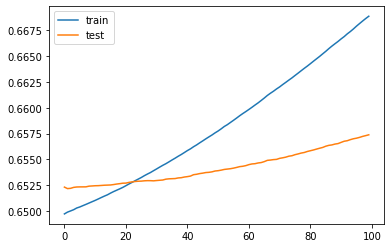

In [77]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.plot(scores[:, 0], label='train')
plt.plot(scores[:, 1], label='test')
plt.legend()

### Loss

> WARP: Weighted Approximate-Rank Pairwise loss. Maximises
  the rank of positive examples by repeatedly sampling negative
  examples until rank violating one is found. Useful when only
  positive interactions are present and optimising the top of
  the recommendation list (precision@k) is desired.

In [79]:
model = LightFM(loss='warp')

scores = []
for e in range(100):
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    scores.append((auc_train, auc_test))
    
scores = np.array(scores)

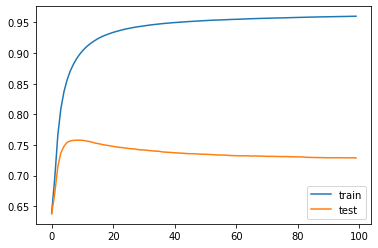

In [80]:
from matplotlib import pyplot as plt

plt.plot(scores[:, 0], label='train')
plt.plot(scores[:, 1], label='test')
plt.legend()

### Activity

Take 5 minutes to explore different epoch and loss combinations

### Early Stopping

In [81]:
from copy import deepcopy

model = LightFM(loss='warp')

count = 0
best = 0
scores = []
for e in range(100):
    if count > 5: # patience
        break
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    print(f'Epoch: {e}, Train AUC={auc_train:.3f}, Test AUC={auc_test:.3f}')
    scores.append((auc_train, auc_test))
    if auc_test > best:
        best_model = deepcopy(model)
        best = auc_test
    else:
        count += 1

model = deepcopy(best_model)

Epoch: 0, Train AUC=0.642, Test AUC=0.639
Epoch: 1, Train AUC=0.704, Test AUC=0.677
Epoch: 2, Train AUC=0.771, Test AUC=0.717
Epoch: 3, Train AUC=0.813, Test AUC=0.738
Epoch: 4, Train AUC=0.840, Test AUC=0.748
Epoch: 5, Train AUC=0.859, Test AUC=0.753
Epoch: 6, Train AUC=0.874, Test AUC=0.756
Epoch: 7, Train AUC=0.885, Test AUC=0.758
Epoch: 8, Train AUC=0.893, Test AUC=0.759
Epoch: 9, Train AUC=0.901, Test AUC=0.758
Epoch: 10, Train AUC=0.906, Test AUC=0.757
Epoch: 11, Train AUC=0.911, Test AUC=0.757
Epoch: 12, Train AUC=0.916, Test AUC=0.757
Epoch: 13, Train AUC=0.919, Test AUC=0.756
Epoch: 14, Train AUC=0.923, Test AUC=0.755


### New Predictions

In [82]:
user = 'aaron67'
df[df['user'] == user]

,item,user,review
13806,Mike and Ike Sour Licious Zours,aaron67,4
14073,Kit Kat Minis Crisp Wafers in Milk Chocolate,aaron67,5
14396,Reese's Peanut Butter Cup Pumpkins Milk Chocolate,aaron67,5
15153,Snickers Crisper Chocolate Bar,aaron67,1
15296,Snickers Peanut Butter Squared Bars,aaron67,5
16867,Reese's Peanut Butter Heart,aaron67,5


In [83]:
im.user_encoder.transform([user])[0]

0

In [84]:
user_id = im.user_encoder.transform([user])[0]

In [85]:
preds = model.predict(user_id, list(range(im.n_items)))
preds = pd.DataFrame(zip(preds, im.item_encoder.classes_), columns=['pred', 'item'])
preds = preds.sort_values('pred', ascending=False)
preds.head()

,pred,item
28,1.573079,Ghirardelli Squares Peppermint Bark
97,1.501575,Reese's Pieces Peanut Butter Candy
98,1.393623,Reese's Reeses Peanut Butter Trees
95,1.353126,Reese's Peanut Butter Egg
48,1.265030,Hershey's Whoppers Malted Milk Balls


In [86]:
tried = df[df['user'] == user]['item'].values
list(preds[~preds['item'].isin(tried)]['item'].values[:5])

['Ghirardelli Squares Peppermint Bark',
 "Reese's Pieces Peanut Butter Candy",
 "Reese's Reeses Peanut Butter Trees",
 "Reese's Peanut Butter Egg",
 "Hershey's Whoppers Malted Milk Balls"]